# Analyse tha thinks

In [57]:
import pandas as pd
from matplotlib import pyplot
import statsmodels.api as sm
import json
import glob

## Defs

In [58]:
agencies = ['kna', 'sda', 'cic', 'kap']
path_in = '../data_cleaned/article/'

## Load files

In [ ]:
filelist = glob.glob("%s*.json" % path_in)
records = []
for f in filelist:
    with open(f, encoding='utf-8') as json_file:
        records.append(json.load(json_file))

In [ ]:
df = pd.DataFrame(records)
df['date'] = pd.to_datetime(df['date'])

# Analyze

## Articles per day
https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621

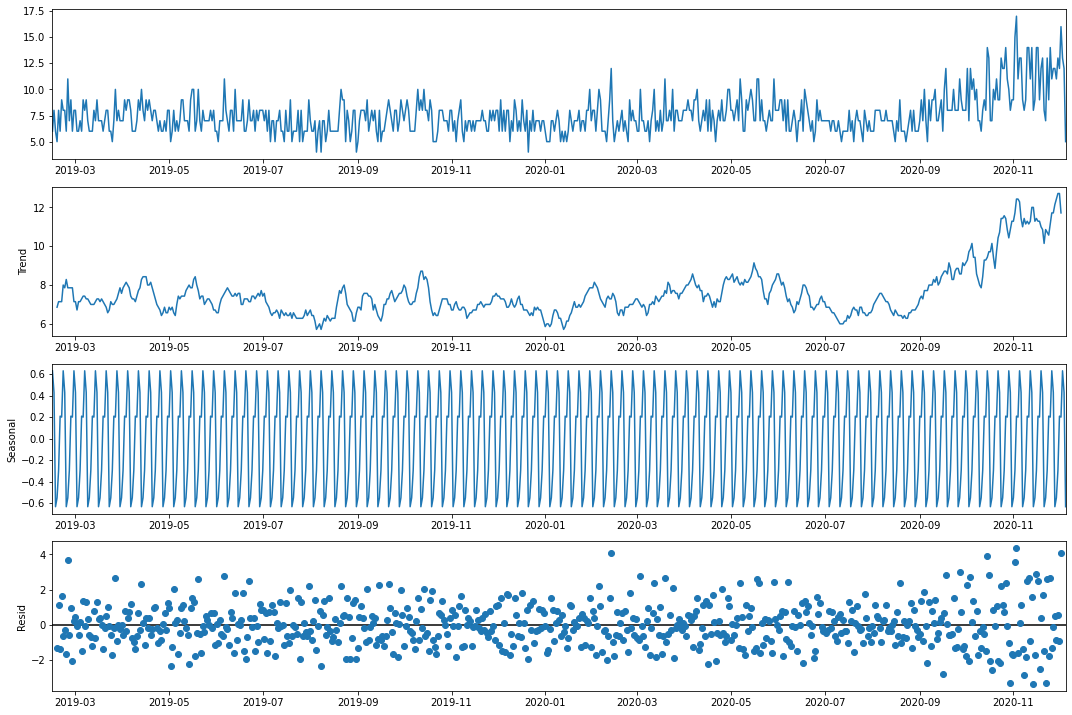

In [22]:
df_data = df.copy()
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])
gr = df_data.groupby('_date').agg({'id': 'count'})#.reset_index()

decomposition = sm.tsa.seasonal_decompose(gr, model = 'additive')
pyplot.rcParams['figure.figsize'] = [15, 10]
fig = decomposition.plot()

## Top Writers
CIC = "Centrum Informationis Catholicum"

<AxesSubplot:xlabel='author'>

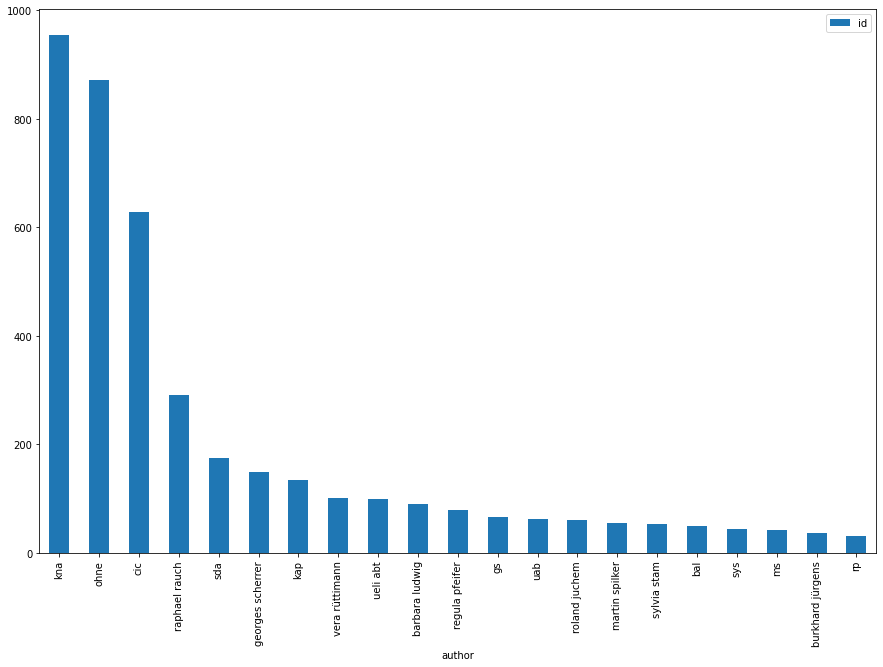

In [23]:
df_data = df.copy()

df_data['author'] = df_data['author'].fillna('ohne')

gr = df_data.groupby(df_data.author.str.lower()).agg({'id': 'count'}).sort_values('id', ascending=False)
gr = gr[gr['id'] >= 30]
gr.plot.bar()

## Writer by time

In [28]:
# Get Top Writers
df_data = df.copy()

df_data['author'] = df_data['author'].fillna('ohne')

df_top = df_data.groupby(df_data.author.str.lower()).agg({'id': 'count'}).sort_values('id', ascending=False)
df_top = df_top[df_top['id'] >= 40]
df_top['top'] = True

<AxesSubplot:xlabel='_date'>

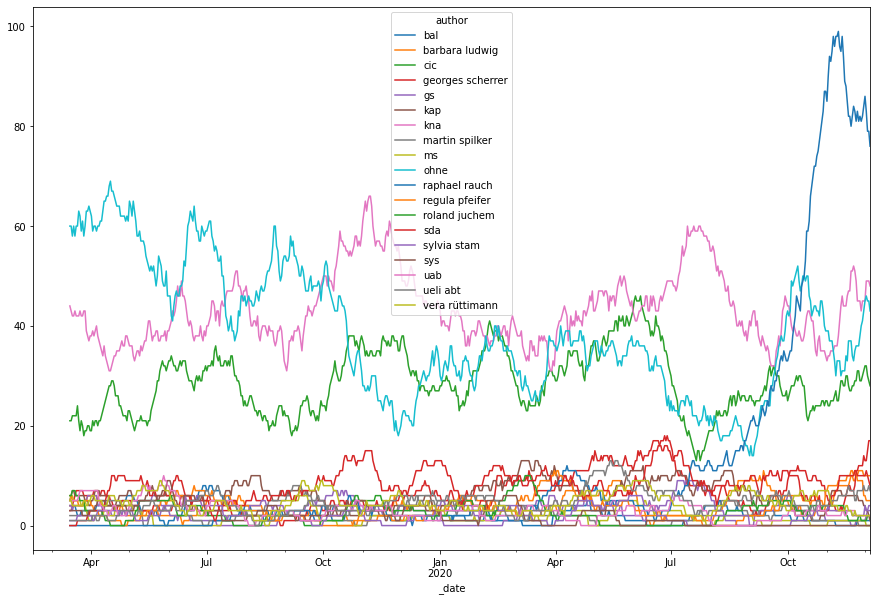

In [29]:
df_data = df.copy()

df_data['author'] = df_data['author'].fillna('ohne')

# Lower Case
df_data['author'] = df_data['author'].str.lower()

# Join
df_data = df_data.merge(df_top, how='left', on='author')
df_data['top'] = df_data['top'].fillna(False)

# Only top authors
df_data = df_data[df_data.top]

# Add Agency
df_data['agency'] = df_data['author'].apply(lambda x: x in agencies)
#df_data = df_data[df_data.agency == False]

#df_data = df_data[df_data.author != 'raphael rauch']

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])

#df_data = df_data[['_date', 'author', 'title']]

gr = pd.pivot_table(df_data, index='_date', columns='author', values='title', aggfunc='count')
gr = gr.fillna(0)

# Add Rolling AVG
gr = gr.apply(lambda col: col.rolling(30).sum(), axis = 0)

gr.plot.line()

#df_data.groupby('author').count()



## Kategorie Type

<AxesSubplot:xlabel='_date'>

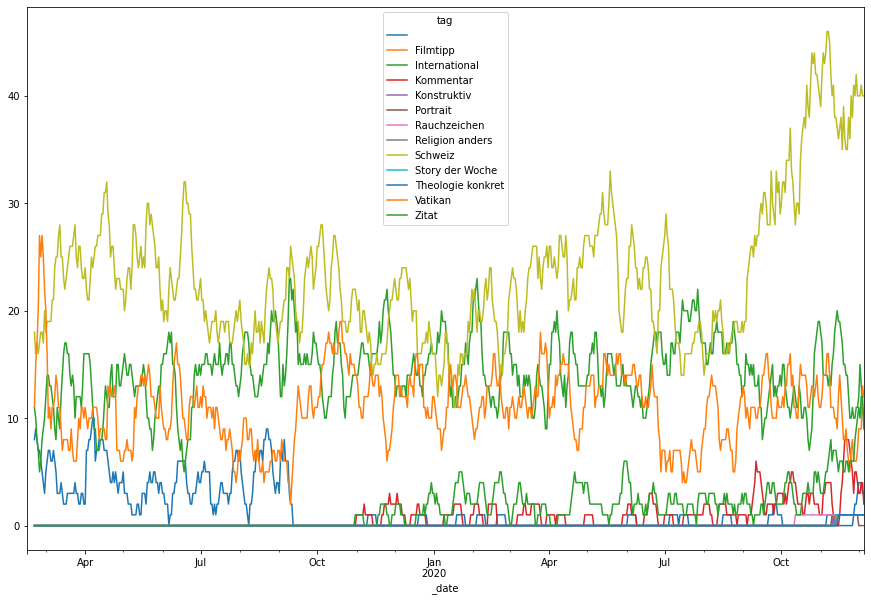

In [10]:
df_data = df.copy()

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])


gr = pd.pivot_table(df_data, index='_date', columns='tag', values='title', aggfunc='count')
gr = gr.fillna(0)

# Add Rolling AVG
gr = gr.apply(lambda col: col.rolling(7).sum(), axis = 0)

gr.plot.line()

<AxesSubplot:xlabel='_date'>

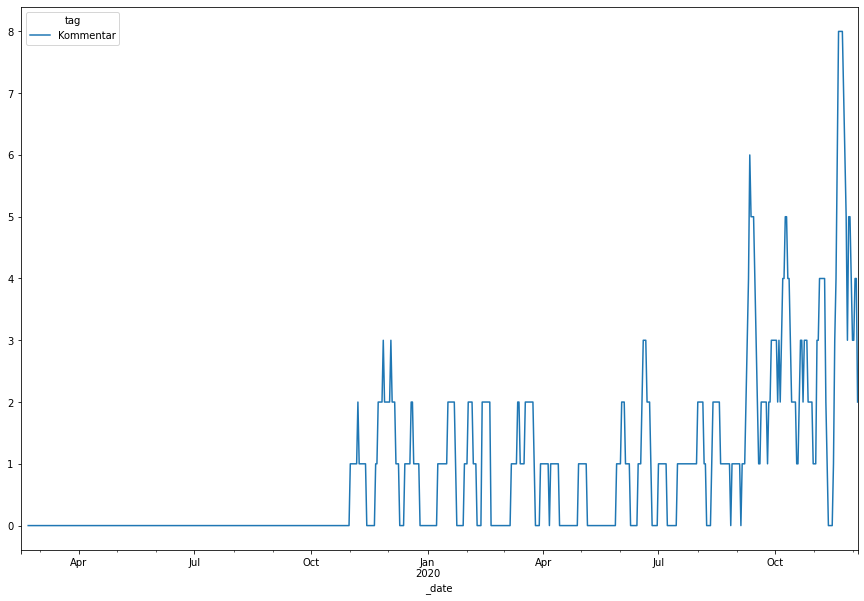

In [11]:
gr[['Kommentar']].plot.line()

## Was schreibt Rauch?

<AxesSubplot:xlabel='tag'>

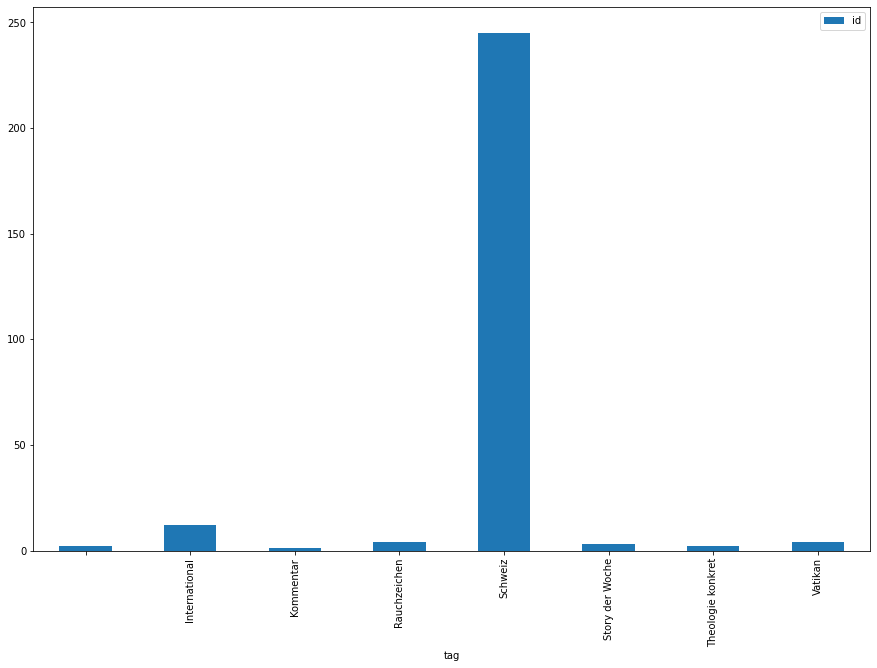

In [12]:
df_data = df.copy()

df_data['author'] = df_data['author'].str.lower()

df_data = df_data[df_data.author == 'raphael rauch']

# Group Category
df_data.groupby('tag').agg({'id': 'count'}).plot.bar()



## Occurence of "Chur", etc

<AxesSubplot:xlabel='_date'>

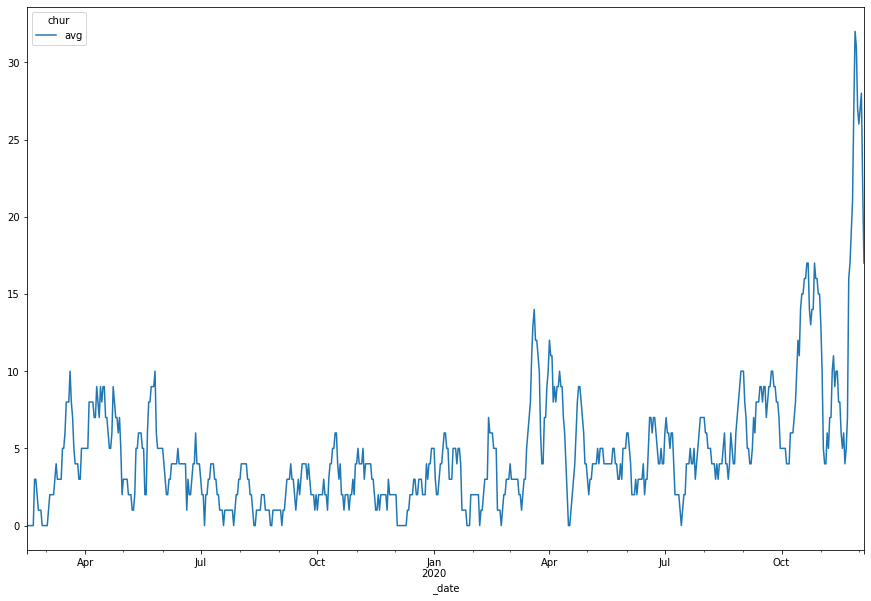

In [56]:
# Wordlist
wordlist = ['chur', 'grichting', 'huonder', 'domkapitel']

df_data = df.copy()

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])

# Add Chur
df_data['chur'] = df_data.text.apply(lambda x: any(s.lower() in x.lower() for s in wordlist))

# Select Only Chur
#df_data = df_data[df_data.chur]

# Group by
gr = pd.pivot_table(df_data, index='_date', values='id', columns = 'chur', aggfunc = 'count')

gr[True] = gr[True].fillna(0)

gr = gr.drop(columns=[False])

# Add Rolling AVG
gr['avg'] = gr[True].rolling(7).sum()#apply(lambda x: x.rolling(7).sum())
gr['avg'] = gr['avg'].fillna(0)

#gr.plot()
gr[['avg']].plot()

In [14]:
df_data.head()

,id,tag,title,text,date,author
54,ab-1-dezember-wallis-erlaubt-gottesdienste-mit...,Schweiz,Ab 1. Dezember: Wallis erlaubt Gottesdienste m...,\nAufatmen im Wallis: Der Staatsrat lockert di...,2020-11-20 17:18:00,raphael rauch
64,abt-urban-federer-kritisiert-schwyzer-behoerden,Schweiz,Abt Urban Federer kritisiert Schwyzer Behörden,\nIm Kanton Schwyz sind Gottesdienste mit über...,2020-10-27 14:57:00,raphael rauch
83,aeschbacher-die-alten-rituale-funktionieren-im...,Schweiz,Aeschbacher: «Die alten Rituale funktionieren ...,\nEin Interview mit TV-Star Kurt Aeschbacher (...,2020-06-20 12:00:00,raphael rauch
86,afrika-expertin-andrea-gmuer-argumentiert-rass...,Schweiz,Afrika-Expertin: «Andrea Gmür argumentiert ras...,\nIn der Debatte um die Konzernverantwortungsi...,2020-11-21 12:00:00,raphael rauch
100,allerheiligen-mit-viel-licht-in-zeiten-der-fin...,Schweiz,Allerheiligen mit viel Licht in «Zeiten der Fi...,"\n«Memento mori», «Gedenke des Todes»: Zu Alle...",2020-10-31 07:22:00,raphael rauch


In [15]:
df_data.sort_values('date', ascending=False).head(10)

,id,tag,title,text,date,author
3645,quellen-der-kraft-zisterzienserinnen-mit-neuem...,Schweiz,«Quellen der Kraft»: Zisterzienserinnen mit ne...,\nSie sind in der Schweiz katholische YouTube-...,2020-12-05 09:53:00,raphael rauch
2663,medizinhistoriker-warnt-vor-eugenik-bei-corona...,Schweiz,Medizinhistoriker warnt vor Eugenik bei Corona...,\nDer Medizinhistoriker Flurin Condrau beobach...,2020-12-04 11:42:00,raphael rauch
4966,zum-barbara-tag-warum-die-option-fuer-die-arme...,Schweiz,Zum Barbara-Tag: Warum die «Option für die Arm...,\nHeute ist Barbara-Tag. Der Namenstag erinner...,2020-12-04 05:56:00,raphael rauch
458,bischof-peter-buercher-fehlt-bei-vollversammlu...,Schweiz,Bischof Peter Bürcher fehlt bei Vollversammlun...,\nDer Churer Generalvikar Martin Grichting hat...,2020-12-02 12:01:00,raphael rauch
1774,grichtings-verhalten-der-bischof-darf-das-so-n...,Schweiz,Grichtings Verhalten: «Der Bischof darf das so...,\nDas Domkapitel in Chur hätte einen neuen Bis...,2020-12-02 11:16:00,raphael rauch
2144,kaempferin-mit-wunderbarem-humor-die-schweiz-t...,Schweiz,«Kämpferin mit wunderbarem Humor»: Die Schweiz...,\nLiliane Juchli war ein Mensch von «professio...,2020-12-02 05:16:00,raphael rauch
2270,katholiken-hoffen-auf-die-ehe-fuer-alle,Schweiz,Katholiken hoffen auf die «Ehe für alle»,\nDie «Ehe für alle» rückt näher. Der Ständera...,2020-12-01 17:59:00,raphael rauch
578,bundesrat-ignazio-cassis-besucht-den-bischof-v...,Schweiz,Bundesrat Ignazio Cassis besucht den Bischof v...,\nDer Schweizer Kapuziner Paul Hinder ist Bisc...,2020-12-01 15:39:00,raphael rauch
3518,penis-affaere-im-bistum-chur-priester-einigt-s...,Schweiz,Penis-Affäre im Bistum Chur: Priester einigt s...,\nEin Priester im Kanton Nidwalden hatte aus V...,2020-11-30 17:57:00,raphael rauch
1158,domkapitelleaks-diese-domherren-liessen-die-bi...,Schweiz,#DomkapitelLeaks: Diese Domherren liessen die ...,\nElf Domherren um Generalvikar Martin Grichti...,2020-11-30 12:24:00,raphael rauch


In [16]:
df[df.title == 'Sieg der Religionsfreiheit']

,id,tag,title,text,date,author
3908,sieg-der-religionsfreiheit,Kommentar,Sieg der Religionsfreiheit,\nSeit Wochen sind in Genf Gottesdienste verbo...,2020-12-03 18:25:00,NaN


In [17]:
df[df.author.isna()].sort_values('date', ascending=False).head(20)

,id,tag,title,text,date,author
1649,gaenswein-stimme-von-benedikt-ist-schwach-aber...,Vatikan,"Gänswein: Stimme von Benedikt ist schwach, abe...",\nAnders als in einzelnen italienischen Medien...,2020-12-04 15:27:00,NaN
3908,sieg-der-religionsfreiheit,Kommentar,Sieg der Religionsfreiheit,\nSeit Wochen sind in Genf Gottesdienste verbo...,2020-12-03 18:25:00,NaN
647,churer-domkapitel-was-der-kanton-schwyz-werner...,Schweiz,Churer Domkapitel: Was der Kanton Schwyz Werne...,\nWerner Inderbitzin war langjähriger Chef der...,2020-12-03 16:07:00,NaN
4447,verliererin-die-kirchen-haben-an-profil-gewonnen,Kommentar,Verliererin? Die Kirchen haben an Profil gewon...,\nDie KVI-Abstimmung ist vorbei. Laut der CH-M...,2020-12-03 15:49:00,NaN
1775,grichtings-verhalten-erinnert-an-trump,Zitat,Grichtings Verhalten erinnert an Trump,\n«Das Verhalten von M. Grichting und Konsorte...,2020-12-03 11:42:00,NaN
648,churer-domkapitel-wie-inderbitzin-den-kanton-s...,Schweiz,Churer Domkapitel: Wie Inderbitzin den Kanton ...,\nWerner Inderbitzin war langjähriger Chef der...,2020-12-02 16:12:00,NaN
1851,historische-krippen-im-verschneiten-wald,Schweiz,Historische Krippen im verschneiten Wald,\nDas Zürcher Landesmuseum zeigt Krippen aus d...,2020-12-02 10:00:00,NaN
2742,missionsgesellschaft-bethlehem-schliesst-missb...,Schweiz,Missionsgesellschaft Bethlehem beendet Missbra...,\nVier Priester der Missionsgesellschaft Bethl...,2020-12-01 15:39:00,NaN
1255,eine-andere-sicht-auf-den-hof-in-chur,,Eine andere Sicht auf den Hof in Chur,\nStimmungsmache gegen den Hof in Chur orten v...,2020-12-01 10:53:00,NaN
4587,was-ist-der-sinn-des-lebens-klara-obermueller,Zitat,"Was ist der Sinn des Lebens, Klara Obermüller?","\n«Leben! So einfach ist das eigentlich, auch ...",2020-12-01 06:36:00,NaN


## Others

In [35]:
df_data = df.copy()

df_data['url'] = df_data['id'].apply(lambda x: 'https://www.kath.ch/newsd/%s/' % x)

df_data[df_data.author.isna()].sort_values('date', ascending=False).head(50).to_csv('noauthor.csv', sep = ';')